This notebook has been created by the author of the Excel workbook ***ExcelentRBF: Interactive Examples of Interpolation with Radial Basis Functions in Microsoft Excel***, [Daniel Owen](https://www.linkedin.com/in/dan-owen), as a companion to the workbook.<br>

It replicates the surface boundary interpolation example from the workbook that was derived from [1], offering an alternative implementation for those who may prefer reading Python code over working with an Excel-based interface.

As with the workbook, this notebook is distributed under the MIT license, allowing readers to freely reuse and share it, provided the license conditions are met. The author kindly requests acknowledgment of the original work and welcomes feedback from those who find it useful or intend to use it in their own projects.

References: <br>
1. https://geostatisticslessons.com/lessons/implicitrbf <br>
2. https://www.seequent.com/the-spheroidal-family-of-variograms-explained/	<br>
3. Fasshauer, G., 2007. Meshfree Approximation Methods with Matlab. World Scientific Publishing Co. <br>
4. https://help.seequent.com/Geo/2024.1/en-GB/Content/concepts/interpolant-functions.htm <br>
5. J. C. Carr, R. K. Beatson, J. B. Cherrie, T. J. Mitchell, W. R. Fright, B. C. McCallum, and T. R. Evans. 2001. Reconstruction and representation of 3D objects with radial basis functions. In Proceedings of the 28th annual conference on Computer graphics and interactive
    techniques (SIGGRAPH '01). Association for Computing Machinery, New York, NY, USA, 67–76. https://doi.org/10.1145/383259.383266	<br>
6. https://en.wikipedia.org/wiki/Monomial_basis <br>
7. Beatson, Richard K., William A. Light and Stephen D. Billings. “Fast Solution of the Radial Basis Function Interpolation Equations: Domain Decomposition Methods.” SIAM J. Sci. Comput. 22 (2000): 1717-1740. <br>
8. https://help.seequent.com/Geo/5.1/en-GB/Content/concepts/interpolant-functions.htm <br>
9. Zhang, B., Du, L., Khan, U., Tong, Y., Wang, L., and Deng, H.: AdaHRBF v1.0: gradient-adaptive Hermite–Birkhoff radial basis function interpolants for three-dimensional stratigraphic implicit modeling, Geosci. Model Dev., 16, 3651–3674, https://doi.org/10.5194/gmd-16-3651-2023, 2023.	





---

First, define the required imports and some helper Enums and functions.

In [29]:
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

class Interpolants(Enum):
    linear = 0
    thinplatespline = 1
    cubic = 2
    spheroidal = 3

class SpheroidalOrder(Enum):
    three = 3
    five = 5
    seven = 7
    nine = 9

class Drift(Enum):
    none = -1
    constant = 0
    linear = 1

def min_drift_order(selected_interpolant: Interpolants)->Drift:
    """Returns the minimum required drift setting for the selected interpolant.

    Parameters
    ----------
    selected_interpolant : Interpolants
        The selected interpolant Enum.

    Returns
    -------
    Drift
        The minimum Drift Enum required for the selected Interpolant.
    """
    min_drift = {
        selected_interpolant.linear: Drift.constant,
        selected_interpolant.thinplatespline: Drift.linear,
        selected_interpolant.cubic: Drift.linear,
        selected_interpolant.spheroidal: Drift.none
    }
    
    return min_drift[selected_interpolant]


Define the Spheroidal look-up table

In [30]:
def get_spheroidal_lookup_vals(order: SpheroidalOrder)->dict:
    """Returns the spheroidal look-up values for the provided order.

    Parameters
    ----------
    order : SpheroidalOrder
        SpheroidalOrder Enum.

    Returns
    -------
    dict
        Dictionary of spheroidal scaling factors for the given order.
    """
    lookup_table = {
        3: {
            'inflexion_point': 0.5000000000,
            'y_inctercep': 1.1448668045,
            'linear_slope': 0.7500000000,
            'range_scaling': 2.6798340586
        },
        5: {
            'inflexion_point': 0.4082482905,
            'y_inctercep': 1.1660474726,
            'linear_slope': 1.0206207262,
            'range_scaling': 1.5822795750
        },
        7: {
            'inflexion_point': 0.3535533906,
            'y_inctercep': 1.1771820864,
            'linear_slope': 1.2374368671,
            'range_scaling': 1.2008676644
        },
        9: {
            'inflexion_point': 0.3162277660,
            'y_inctercep': 1.1840505048,
            'linear_slope': 1.4230249471,
            'range_scaling': 1.0000000000
        },  
    }

    return lookup_table[order.value]

Define the basic functions.

In [31]:
def linear_basic_function(r: np.ndarray)->np.ndarray:
    return -r

def thin_plate_spline_basic_function(r: np.ndarray)->np.ndarray:
    result = np.zeros_like(r)
    zeros_mask = r != 0
    result[zeros_mask] = r[zeros_mask] ** 2 * np.log(r[zeros_mask])

    return result

def cubic_basic_function(r: np.ndarray)->np.ndarray:
    return r ** 3

def spheroidal_basic_function(
    r: np.ndarray,
    base_range: float,
    sill: float,
    alpha: float
)-> np.ndarray:
    (
        inflexion_point,
        y_intercept,
        linear_slope,
        range_scaling
    ) = get_spheroidal_lookup_vals(alpha).values()
    
    return np.where(
        r <= inflexion_point * (range_scaling ** -1) * base_range,
        sill * (1 - linear_slope * range_scaling * r / base_range),
        sill * (y_intercept ** -1) * (1 + (range_scaling * r / base_range) ** 2) ** (-alpha.value / 2)
    )

Define a function to evaluate the monomial basis.

In [32]:
def evaluate_monomials(points: np.ndarray, order: Drift)->np.ndarray:
    """Evaluates the linear combination of monomials for the given polynomial order.
    This particular implementation has been limited to 2D and 3D scenarios, with at most
    an order of 1 (linear polynomials).
    For constant drift this amounts to a basis size of 1 column, and for linear drift amounts to
    3 columns in 2D and 4 columns in 3D.

    Parameters
    ----------
    points : np.ndarray
        Point coordinates to evaluate, of shape (m, dimensions).
    order : Drift
        Drift enum.

    Returns
    -------
    np.ndarray
        Polynomial matrix, of shape (m, basis_size)
    """
    # If using a constant drift, just return a column of 1's.
    if order == Drift.constant:
        polynomial_matrix = np.ones((points.shape[0], 1))
    # If using a linear drift, return a column of 1's plus a column for each coordinate axis.
    elif order == Drift.linear:
        dimensions = points.shape[1]
        polynomial_matrix = np.zeros((points.shape[0], dimensions + 1))
        
        polynomial_matrix[:, 0] = 1
        polynomial_matrix[:, 1:] = points
    else:
        raise ValueError('Unsupported order')

    return polynomial_matrix


Define a function to calculate the distance matrix.

In [33]:
def get_distance_matrix(target_points: np.ndarray, source_points: np.ndarray)->np.ndarray:
    """Calculates the distance from each target point to each source point.

    Parameters
    ----------
    target_points : np.ndarray
        The target points coordinates, of shape (m, dimensions).
    source_points : np.ndarray
        The source point coordinates, of shape (n, dimensions).

    Returns
    -------
    np.ndarray
        Distance matrix array of shape (m, n).
    """
    # Leverage numpy's broadcasting capabilities to avoid any loops.
    distance_matrix = np.linalg.norm(target_points[:, np.newaxis] - source_points, axis=-1)
    return distance_matrix

Define an RBFInterpolator class to use for interpolation.

In [34]:
class RBFInterpolator:
    """Radial Basis Function (RBF) interpolator for scattered data.

    This class constructs an RBF interpolant for a given set of points and their associated values.
    """
    def __init__(
        self,
        points: np.ndarray,
        point_values: np.ndarray,
        interpolant: Interpolants, 
        drift: Drift, 
        nugget: float = 0.0, 
        alpha : SpheroidalOrder = SpheroidalOrder.three, 
        total_sill: float = 10.0, 
        base_range: float = 1.0
    ):
        """Initialises the RBF interpolator with the given points, values, and settings.

        Parameters
        ----------
        points : np.ndarray
            Input source points.
        point_values : np.ndarray
            Input source values.
        interpolant : Interpolants
           Interpolant Enum to apply.
        drift : Drift
            Drift Enum to apply.
        nugget : float, optional
            Smoothing factor, by default 0.0
        alpha : SpheroidalOrder, optional
            SpheroidalOrder Enum, by default SpheroidalOrder.three
        total_sill : float, optional
            Total sill value, by default 10.0
        base_range : float, optional
            Base range value, by default 1.0
        """
        # Assign anything needed later during evaluation to class attributes.
        self.points = points
        self.interpolant = interpolant
        self.drift = drift
        self.nugget = nugget
        self.alpha = alpha
        self.total_sill = total_sill
        self.base_range = base_range

        # Compute the basic function values for the solver matrix.
        solver_basic_function_values = self._get_basic_function_values(self.points, self.points)

        # Add nugget (smoothing factor) to the diagonal of the solver matrix.
        np.fill_diagonal(solver_basic_function_values, solver_basic_function_values.diagonal() + nugget)

        # Check that an appropriate minimum drift has been selected for the chosen basic function.
        min_interpolant_drift = min_drift_order(self.interpolant)

        if not self.drift.value >= min_interpolant_drift.value:
            raise ValueError(f"Minimum drift for {self.interpolant} is: {min_interpolant_drift}")

        # If drift is used, augment the system with polynomial terms.
        if self.drift != Drift.none:
            monomial_basis = evaluate_monomials(self.points, self.drift)
            
            # Build the full system for coefficients solving.
            lhs = np.column_stack((solver_basic_function_values, monomial_basis))
            lhs_bottom = np.column_stack((
                monomial_basis.T, np.zeros((monomial_basis.shape[1], monomial_basis.shape[1]))))
            lhs = np.vstack((lhs, lhs_bottom))
            rhs = np.hstack((point_values, np.zeros(monomial_basis.shape[1])))
        else:
            # Basic RBF interpolation without drift.
            lhs = solver_basic_function_values
            rhs = point_values

        # Solve the linear system to find interpolation coefficients.
        self.coefficients = np.linalg.solve(lhs, rhs)

    def _get_basic_function_values(self, targets: np.ndarray, sources: np.ndarray)->np.ndarray:
        """Calculates the distance between each target point and each source point, then evaluates
        the distances using the defined basic function.

        Parameters
        ----------
        targets : np.ndarray
            Target point coordinates, of shape (m, dimensions).
        sources : np.ndarray
            Source point coordinates, of shape (n, dimensions).

        Returns
        -------
        np.ndarray
            Basic function values for the solver matrix, of shape(m, n).
        """
        # Calculate the distances between each target point and source point.
        distance_matrix = get_distance_matrix(targets, sources)

        # Evaluate the distances with the defined basic function.
        if self.interpolant == Interpolants.linear:
            solver_basic_function_values = linear_basic_function(distance_matrix)
        elif self.interpolant == Interpolants.thinplatespline:
            solver_basic_function_values = thin_plate_spline_basic_function(distance_matrix)
        elif self.interpolant == Interpolants.cubic:
            solver_basic_function_values = cubic_basic_function(distance_matrix)
        elif self.interpolant == Interpolants.spheroidal:
            solver_basic_function_values = spheroidal_basic_function(
                distance_matrix, self.base_range, self.total_sill, self.alpha)
        return solver_basic_function_values


    def __call__(self, targets: np.ndarray)->np.ndarray:
        """Evaluates the RBF at the provided target locations.

        Parameters
        ----------
        targets : np.ndarray
            Target coordinates.

        Returns
        -------
        np.ndarray
            Interpolated values at the target locations.
        """
        # Compute the basic function values for the evaluator.
        evaluator_basic_function_values = self._get_basic_function_values(targets, self.points)

        # If drift is included, augment with monomial terms.
        if self.drift != Drift.none:
            targets_monomials = evaluate_monomials(targets, self.drift)
            evaluation_vectors = np.column_stack((evaluator_basic_function_values, targets_monomials))
        else:
            # Basic RBF evaluation without drift.
            evaluation_vectors = evaluator_basic_function_values

        # Apply the computed coefficients to get interpolated values.
        target_interpolated_values = evaluation_vectors @ self.coefficients

        return target_interpolated_values

Define the input samples and their values, then solve the RBF for the coefficients.

In [35]:
# Define 2D point locations for the surface boundary example.
input_samples = np.array([
    [2.0, 13.0],
    [7.5, 12.0],
    [6.0, 7.0],
    [10.0, 6.0],
    [5.0, 4.0],
    [11.0, 12.0],
    [3.0, 10.0],
    [11.0, 8.0],
    [2.5, 6.0],
    [12.5, 4.0],
    [10.0, 2.0],
    [2.5, 11.5],
    [9.25, 12.0],
    [11.25, 5.0],
    [3.75, 5.0],
])

# Define the signed distance values at the input sample points.
input_values = np.array([
    -1.000,
    -1.000,
    -1.000,
    -1.000,
    -1.000,
    1.000,
    1.000,
    1.000,
    1.000,
    1.000,
    1.000,
    0.000,
    0.000,
    0.000,
    0.000,
])

# Define the interpolant basic function to use.
interpolant = Interpolants.linear

# Define the drift to use.
drift = Drift.linear

# Initialise an RBFInterpolator and solve for the coefficients.
rbfi = RBFInterpolator(input_samples, input_values, interpolant, drift)

print(f'Coefficients are: {rbfi.coefficients}')

Coefficients are: [-0.24352614 -0.33394229 -0.25461639 -0.53487657 -0.37452007  0.20797279
  0.4681523   0.42919214  0.34455296  0.07834561  0.2232889   0.02110901
  0.01967109 -0.10538618  0.05458283  0.81077489  0.11990019 -0.10274721]


Define the evaluation points and evaluate the RBF using the interpolant.

In [36]:
# Define a 2D grid of points to evaluate between 0-15 in the X dimension
# and 0-15 in the Y dimension.
x_evaluation = np.arange(0, 15 + 0.2, 0.2)

y_evaluation = np.arange(0, 15 + 0.2, 0.2)

xx, yy = np.meshgrid(x_evaluation, y_evaluation)

evaluation_points = np.column_stack((xx.ravel(), yy.ravel()))

# Evaluate the RBF at the target evaluation points using the interpolant.
target_interpolated_values = rbfi(evaluation_points)

# Find the value at a particular coordinate from the evaluated points.
query_interpolated_coords = np.array([2.0, 13.0])

query_value_index = np.where(np.isclose(evaluation_points, query_interpolated_coords).all(axis=1))[0]

query_value = target_interpolated_values[query_value_index]

print(f'Interpolated value at {query_interpolated_coords}: {query_value}')

Interpolated value at [ 2. 13.]: [-1.]


Create a plot of the interpolated grid values.

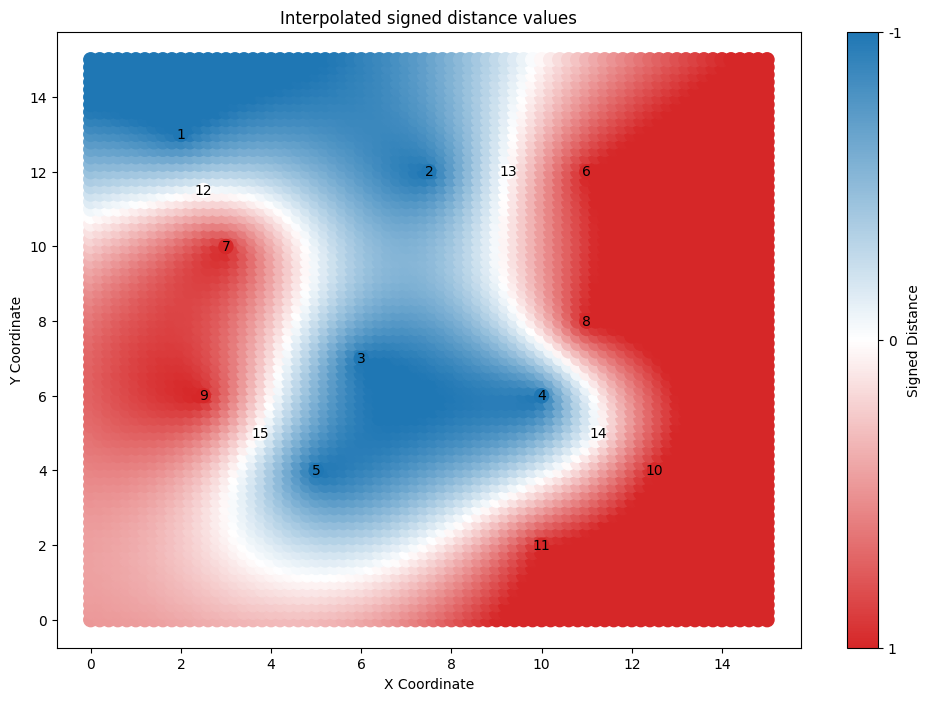

In [37]:
# Define the colourmap.
cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 'tab:blue'), (0.5, 'white'), (1, 'tab:red')]
)

# Normalise the signed distance values for the plot.
norm = Normalize(vmin=-1, vmax=1)

# Set figure size
plt.figure(figsize=(12, 8))

# Create the scatter plot of the evaluation points.
plt.scatter(evaluation_points[:, 0], evaluation_points[:, 1], c=target_interpolated_values, cmap=cmap, norm=norm, s=100)

# Plot the input sample points.
plt.scatter(input_samples[:, 0], input_samples[:, 1], c=input_values, cmap=cmap, norm=norm, marker='o', s=100)

# Add text labels for input sample points
for i, (x, y) in enumerate(input_samples):
    plt.text(x, y, str(i + 1), fontsize=10, ha='center', va='center', color='black')

# Add a colorbar.
cbar = plt.colorbar()
cbar.set_label('Signed Distance')
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['-1', '0', '1'])
cbar.ax.invert_yaxis()

# Label axes.
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Interpolated signed distance values')

# Show plot.
plt.show()